In [1]:
import pandas as pd
import requests
from datetime import datetime, timedelta
import concurrent.futures
import re
import statsapi
import pprint
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import streamlit as st

from streamlit_jupyter import StreamlitPatcher, tqdm

StreamlitPatcher().jupyter()

from IPython.display import display, clear_output

pd.set_option('display.max_columns', None)

In [2]:
def findTeamKeys():
    mlbTeamKeys = []
    url = "https://statsapi.mlb.com/api/v1/teams/"
    response = requests.get(url)



    data = response.json()
    for team in data['teams']:
        #if team.get('sport', {}).get('name', '') == "Major League Baseball":
        mlbTeamKeys.append(
            {
            'Team' : team.get('name'),
            'team_id' : team.get('id'),
            'team_abbr' : team.get('abbreviation'),
            'league' : team.get('league',{}).get('name'),
            'division' : team.get('division',{}).get('name'),
            'sport' : team.get('sport', {}).get('name')
            }
        )
    return pd.DataFrame(mlbTeamKeys)

statsApiTeamKeys = findTeamKeys()
mlbTeamKeys = statsApiTeamKeys[statsApiTeamKeys['sport'] == 'Major League Baseball']

team_ids = mlbTeamKeys['team_id'].to_list()

In [3]:
daySlate = []
current_date = datetime.now()
# current_date = datetime.now() + timedelta(days=1)

def fetch_schedule(team_id, current_date=current_date.strftime('%Y-%m-%d')):
    sched = statsapi.schedule(date=current_date,team=team_id)
    return sched

with ThreadPoolExecutor(max_workers=30) as executor:
    future_to_team = {executor.submit(fetch_schedule, team): team for team in team_ids}

    for future in as_completed(future_to_team):
        sched = future.result()
        for game in sched:
            # Convert game dict to a hashable form (tuple of items) for storing in a set
            if game not in daySlate:
                daySlate.append(game)

daySlate = pd.DataFrame(daySlate)
daySlate.to_csv('datasets/daySlate.csv', index = False)

In [4]:
batter_boxscores = pd.read_csv('datasets/batterBoxscores.csv', low_memory=False).sort_values(by='game_date')
pitcher_boxscores = pd.read_csv('datasets/pitcherBoxscores.csv', low_memory=False).sort_values(by='game_date')

all_play_by_play = pd.read_csv('datasets/all_play_by_play.csv')
strikeouts_per_inning = pd.read_csv('datasets/k_per_inning.csv')
walks_per_inning = pd.read_csv('datasets/bb_per_inning.csv')
hits_allowed_per_inning = pd.read_csv('datasets/h_per_inning.csv')
all_play_by_play['pitcher_pitches_thrown_in_inning'] = all_play_by_play.groupby(['game_ID', 'inning', 'pitcher_id']).cumcount() + 1

def correct_team_name(row):
    if row['team_id'] == row['away_id']:
        return row['away_name']
    elif row['team_id'] == row['home_id']:
        return row['home_name']
    else:
        return row['Team']  # Return the original value if no match found
    
def find_opponent(row):
    if row['team_id'] == row['away_id']:
        return row['home_name']
    else:
        return row['away_name']



batter_boxscores['singles'] = batter_boxscores['h'] - batter_boxscores['doubles']- batter_boxscores['triples']- batter_boxscores['hr']

batter_boxscores['Team'] = batter_boxscores.apply(correct_team_name, axis=1)
pitcher_boxscores['Team'] = pitcher_boxscores.apply(correct_team_name, axis=1)

batter_boxscores['Opponent'] = batter_boxscores.apply(find_opponent, axis=1)
pitcher_boxscores['Opponent'] = pitcher_boxscores.apply(find_opponent, axis=1)

batter_boxscores['isWinner'] = batter_boxscores['Team'] == batter_boxscores['winning_team']
pitcher_boxscores['isWinner'] = pitcher_boxscores['Team'] == pitcher_boxscores['winning_team']

pitcher_boxscores['isStarter'] = pitcher_boxscores.apply(lambda row: row['Name'] in [row['home_probable_pitcher'], row['away_probable_pitcher']], axis=1)
pitcher_boxscores['pitcherIsWinner'] = pitcher_boxscores.apply(lambda row: row['Name'] == row['winning_pitcher'], axis=1)

def innings_to_outs(ip):
    whole, fraction = divmod(ip, 1)
    # Convert the fractional part to a proportion of an inning and multiply by 3 to get the outs
    fraction_outs = round(fraction * 10)  # Convert .1, .2, etc. to 1, 2, etc.
    total_outs = int(whole) * 3 + fraction_outs
    return total_outs

# Apply the conversion function to the 'ip' column
pitcher_boxscores['pitching_outs'] = pitcher_boxscores['ip'].apply(innings_to_outs)

pitcher_boxscores['pitches_per_out'] = round(pitcher_boxscores['p'] /  pitcher_boxscores['pitching_outs'],2)

batter_boxscores['seasonNumber'] = pd.to_datetime(batter_boxscores['game_date']).dt.year

pitcher_boxscores['seasonNumber'] = pd.to_datetime(pitcher_boxscores['game_date']).dt.year


In [5]:
team_id_df = []


team_url = "https://sports.core.api.espn.com/v2/sports/baseball/leagues/mlb/teams"
team_data = requests.get(team_url).json()['items']

for key in team_data:
    team_url = key['$ref']
    team_info = requests.get(team_url).json()
    team_id_df.append({
        'id' : team_info['id'],
        'Team' : team_info['displayName']
    })

team_id_df = pd.DataFrame(team_id_df)

roster_df = []
record_df = []
next_game_df = []

game_id_list = []


for team_id in team_id_df['id'].to_list():


    team_url = f'https://site.api.espn.com/apis/site/v2/sports/baseball/mlb/teams/{team_id}?enable=roster,projection,stats'
    team_response = requests.get(team_url)
    team_data = team_response.json()

    team_name = team_data['team']['displayName']
    team_abbr = team_data['team']['abbreviation']
    team_id = team_data['team']['id']

    for athlete in team_data['team']['athletes']:
        roster_df.append(
            {
                'Team' : team_name,
                'Abbreviation' : team_abbr,
                'espn_team_id' : team_id,
                'espn_player_id' : athlete.get('id'),
                'Name' : athlete.get('displayName'),
                'weight' : athlete.get('weight'),
                'height' : athlete.get('height'),
                'age' : athlete.get('age'),
                'rookieYear' : athlete.get('debutYear'),
                'jersey' : athlete.get('jersey'),
                'position' : athlete.get('position', {}).get('abbreviation'),
                'experience' : athlete.get('experience', {}).get('years'),
                'isActive' : athlete.get('active'),
                'Bats' : athlete.get('bats', {}).get('abbreviation'),
                'Throws' : athlete.get('throws', {}).get('abbreviation'),
                'Injuries' : athlete.get('injuries')
            }
        )
    
    record_data = team_data['team']['record']
    team_dict = {}
    team_dict['Team'] = team_name
    team_dict['Abbreviation'] = team_abbr
    team_dict['espn_team_id'] = team_id
    for record_type in record_data['items']:
        game_type = record_type['type']
        for stat in record_type['stats']:
            team_dict[f"{game_type}_{stat['name']}"] = stat['value'] 
    team_dict['standingSummary'] = team_data['team']['standingSummary']
    record_df.append(team_dict)

    next_event = team_data['team']['nextEvent'][0]

    next_event_dict = {
            'Team' : team_name,
            'Abbreviation' :  team_abbr,
            'espn_team_id' : team_id,
            'espn_game_id' : next_event.get('id')
        }
    game_data = next_event['competitions'][0]

    next_event_dict['isNeutralSite'] = game_data['neutralSite']
    next_event_dict['game_time'] = game_data['status']['type']['shortDetail']
    next_event_dict['venue'] = game_data['venue']['fullName']

    for team in game_data['competitors']:
        
        if team['team']['displayName'] == team_name:
            next_event_dict['home_or_away'] = team['homeAway']
            next_event_dict['team_probable_starting_pitcher'] = team.get('probables',[{}])[0].get('athlete',{}).get('displayName')
            next_event_dict['team_probable_starting_pitcher_id'] = team.get('probables', [{}])[0].get('athlete',{}).get('id')
        else:
            next_event_dict['opponent'] = team['team']['displayName']
            next_event_dict['opponent_espn_team_id'] = team['team']['id']
            next_event_dict['opponent_probable_starting_pitcher'] = team.get('probables',[{}])[0].get('athlete',{}).get('displayName')
            next_event_dict['opponent_probable_starting_pitcher_id'] = team.get('probables', [{}])[0].get('athlete',{}).get('id')
    next_game_df.append(next_event_dict)


roster_df = pd.DataFrame(roster_df)
record_df = pd.DataFrame(record_df)
next_game_df = pd.DataFrame(next_game_df)

In [6]:
roster_df.to_csv('datasets/roster_df.csv', index=False)

In [7]:
injuryReport = {}


for index, row in roster_df.iterrows():
    if len(row['Injuries']):
        injuryReport[row['Name']] = row['Injuries']


In [8]:
injuryReport.keys()

dict_keys(['Felix Bautista', 'Tyler Burch', 'Keagan Gillies', 'Austin Hays', 'Maikol Hernandez', 'Conner Loeprich', 'Zach Peek', 'Jean Pinto', 'Grayson Rodriguez', 'Terrin Vavra', 'Max Wagner', 'Nate Webb', 'Tyler Wells', 'Brayan Bello', 'Brainer Bonaci', 'Zach Bryant', 'Isaiah Campbell', 'Triston Casas', 'Lucas Giolito', 'Romy Gonzalez', 'Tyler Heineman', 'Liam Hendriks', 'Bryan Mata', 'Chris Murphy', 'Roberto Perez', 'Nick Pivetta', 'Andrew Politi', 'Mikey Romero', 'Noah Song', 'Trevor Story', 'Brandon Walter', 'Garrett Whitlock', 'Jeremy Wu-Yelland', 'Masataka Yoshida', 'Sam Bachman', 'Kelvin Caceres', 'Jose Cisnero', 'Ryan Costeiu', 'Coleman Crow', 'Sadrac Franco', "Logan O'Hoppe", 'Jose Quijada', 'Anthony Rendon', 'Luis Rengifo', 'Miguel Sano', 'Chase Silseth', 'Michael Stefanic', 'Robert Stephenson', 'Mike Trout', 'Evan White', 'Guillermo Zuniga', 'Joe Barlow', 'Sean Burke', 'Ryan Burrowes', 'Shane Drohan', 'Matt Foster', 'Corey Knebel', 'Jimmy Lambert', 'Dominic Leone', 'Davis M

In [9]:
df_reversed = batter_boxscores.iloc[::-1].copy()  # Reverse the DataFrame to have the most recent games at the top
df_reversed = df_reversed[~df_reversed['Name'].isin(injuryReport.keys())]
# Initialize a dictionary to hold the predicted lineup for each team
predicted_lineups = {}

# Process each team separately
for team in df_reversed['team_id'].unique():
    team_df = df_reversed[df_reversed['team_id'] == team]
    # Initialize a list to hold selected players to avoid duplicates
    selected_players = []
    # Initialize the lineup as an empty list
    lineup = []
    
    for position in range(100, 1000, 100):  # Batting positions from 100 to 900
        # Get the last 5 games where the battingOrder matches the current position
        players_in_position = team_df[(team_df['battingOrder'] >= position) & 
                                      (team_df['battingOrder'] < position + 100) &
                                      (~team_df['Name'].isin(selected_players))].head(5)
        
        # Find the most frequent player for the position
        most_frequent_player = players_in_position['Name'].mode().head(1).values
        
        # If a player is found, add them to the lineup and to the list of selected players
        if len(most_frequent_player) > 0:
            player_name = most_frequent_player[0]
            lineup.append(player_name)
            selected_players.append(player_name)
            
        # Break the loop if we have filled all 9 positions
        if len(lineup) >= 9:
            break
    
    predicted_lineups[team] = lineup

# Now, predicted_lineups contains the predicted 9-man lineup for each team based on the last 5 games
pd.DataFrame(predicted_lineups).to_csv('datasets/predicted_lineups.csv', index=False)

In [15]:
team_list = df_reversed['Team'].unique()

# Assuming 'predicted_lineups' is your dictionary with team names as keys and lists of player names as values

# Create the team dropdown
team_dropdown = widgets.Dropdown(
    value=None,
    options=sorted(team_list),
    description='Team:'
)

# Initially, the player dropdown will not be displayed until a team is selected
player_dropdown = widgets.Dropdown(
    description='Player:',
    options=[],
    value=None
)

prop_dropdown = widgets.Dropdown(
    description='Prop Type:',
    options=['r', 'h', 'singles', 'doubles', 'triples', 'hr', 'rbi', 'sb', 'bb', 'TB', 'k'],
    value=None
)

prop_line = widgets.FloatText(
    value=0.0,
    description='Prop Line:',
    disabled=False,
    step=0.5
)

submit_button = widgets.ToggleButton(
    value=False,
    description='Submit',
    disabled=False

)

opponent_dropdown = widgets.Dropdown(
    description='Opponent:',
    value=None,
    options=sorted(team_list)
)

number_of_games = widgets.IntSlider(
    value = 10,
    min=1,
    max=50,
    step=1,
    description='# of Games Back',
    orientation='horizontal',
    readout=True,

)

isWin = widgets.Dropdown(
    description='Team Won game?:',
    options=[True,False,None],
    value=None
)

homeOrAway = widgets.Dropdown(
    description='H/A:',
    options=['home','away','both'],
    value='both'
)
# Output widget to display the selected player
output = widgets.Output()

def on_team_change(change):
    if change['new']:
        team_id = df_reversed[df_reversed['Team'] == change['new']]['team_id'].iloc[0]
        # Update player dropdown options based on selected team
        player_dropdown.options = sorted(predicted_lineups[team_id])
        player_dropdown.value = None  # Reset player dropdown value
        clear_output()
        hbox = widgets.HBox([team_dropdown,player_dropdown])
        display(hbox)
        # display(team_dropdown)
        # display(player_dropdown)  # Make sure to display/update the player dropdown
    else:
        player_dropdown.options = []

def on_player_change(change):
    if change['new']:
        clear_output()

        hbox = widgets.HBox([team_dropdown,player_dropdown, prop_dropdown, prop_line, isWin, homeOrAway, opponent_dropdown, number_of_games],  layout=widgets.Layout(display='flex', flex_flow='row wrap'))
        display(hbox)

        container = widgets.HBox([submit_button])
        container.layout.justify_content = 'center'
        display(container)
        player_name = player_dropdown.value
    else:
        print("No player selected.")

def on_prop_change(change):
    if change['new']:

        hbox = widgets.HBox([team_dropdown,player_dropdown, prop_dropdown, prop_line, isWin, homeOrAway, opponent_dropdown, number_of_games], layout=widgets.Layout(display='flex', flex_flow='row wrap'))
        clear_output()
        display(hbox)

        container = widgets.HBox([submit_button])
        container.layout.justify_content = 'center'
        display(container)

    else:
        print('No prop selected')

def prop_line_update(change):
    if change['new']:
        new_value = change['new']
        rounded_value = round(new_value * 2) / 2.0
        # Update the widget's value if it's different
        if new_value != rounded_value:
            prop_line.value = rounded_value

        hbox = widgets.HBox([team_dropdown,player_dropdown, prop_dropdown, prop_line, isWin, homeOrAway, opponent_dropdown, number_of_games], layout=widgets.Layout(display='flex', flex_flow='row wrap'))
        clear_output()
        display(hbox)

        container = widgets.HBox([submit_button])
        container.layout.justify_content = 'center'
        display(container)

def isWin_change(change):
    if change['new']:

        hbox = widgets.HBox([team_dropdown,player_dropdown, prop_dropdown, prop_line, isWin, homeOrAway, opponent_dropdown, number_of_games],  layout=widgets.Layout(display='flex', flex_flow='row wrap'))
        clear_output()
        display(hbox)

        container = widgets.HBox([submit_button])
        container.layout.justify_content = 'center'
        display(container)

def homeAway_change(change):
    if change['new']:
        hbox = widgets.HBox([team_dropdown,player_dropdown, prop_dropdown, prop_line, isWin, homeOrAway, opponent_dropdown, number_of_games],  layout=widgets.Layout(display='flex', flex_flow='row wrap'))
        clear_output()
        display(hbox)

        container = widgets.HBox([submit_button])
        container.layout.justify_content = 'center'
        display(container)

def number_of_games_change(change):
    pass

def opponent_change(change):
    pass


def on_submit_button_clicked(change):
    clear_output()

    hbox = widgets.HBox([team_dropdown,player_dropdown, prop_dropdown, prop_line, isWin, homeOrAway, opponent_dropdown, number_of_games],  layout=widgets.Layout(display='flex', flex_flow='row wrap'))
    display(hbox)

    container = widgets.HBox([submit_button])
    container.layout.justify_content = 'center'
    display(container)
    player_name = player_dropdown.value

    current_player = batter_boxscores[batter_boxscores['Name'] == player_name]
    current_player = current_player[current_player['isStarter'] == True]
    if change['new']:
        team_name = team_dropdown.value
        team_id = df_reversed[df_reversed['Team'] == team_name]['team_id'].iloc[0]
        print(team_id)
        final_team_id = team_id

        prop = prop_dropdown.value
        prop_value = prop_line.value



        team_won = isWin.value
        team_homeAway = homeOrAway.value

        number_of_games_size = number_of_games.value

        vsOpponent = opponent_dropdown.value

        if vsOpponent != None:
            current_player = current_player[current_player['Opponent'] == vsOpponent]
        else:
            player_name = player_dropdown.value

            current_player = batter_boxscores[batter_boxscores['Name'] == player_name]
            current_player = current_player[current_player['isStarter'] == True]


        if team_homeAway =='away':
            current_player = current_player[current_player['away_id'] == team_id]
        elif team_homeAway == 'home':
            current_player = current_player[current_player['home_id'] == team_id]

        if team_won != None:
            if team_won:
                current_player = current_player[current_player['isWinner'] == True]
            else:
                current_player = current_player[current_player['isWinner'] == False]



        if number_of_games_size > len(current_player):
            number_of_games_size = len(current_player)

        current_player = current_player.tail(number_of_games_size)[::-1]
        

        prop_totals = current_player[prop].to_list()
        dates = current_player['game_date'].to_list()
        opponents = current_player['Opponent'].to_list()

        # Combine dates and opponents for the x-axis labels
        x_labels = [f"{date}\n{opponent}" for date, opponent in zip(dates, opponents)]

        # Calculate figure size: Here we assume each bar needs a minimum width of 2 inches to display its label without overlap
        fig_width = max(8, len(prop_totals) * 2)  # Ensure a minimum figure width of 8 inches
        fig_height = 8  # A fixed figure height

        # Creating the figure and bar chart with the calculated size
        fig, ax = plt.subplots(figsize=(fig_width, fig_height))
        colors = ['green' if total > prop_value else 'red' if total < prop_value else 'gray' for total in prop_totals]


        bars = ax.bar(range(len(prop_totals)), prop_totals, color=colors)
        ax.axhline(y=prop_value, color='blue', linewidth=2, linestyle='--')

        # Setting the x-axis labels with optimal rotation and alignment
        ax.set_xticks(range(len(x_labels)))
        ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=15)  # Adjust fontsize as needed

        # Setting custom y-axis ticks at increments of 0.5
        max_value = max(prop_totals)
        y_ticks = np.arange(0, max_value + 1, 0.5)
        ax.set_yticks(y_ticks)

        # Setting labels and title
        ax.set_xlabel('Date of Game and Opponent')
        ax.set_ylabel('Values')
        ax.set_title(f"{player_name} {prop} in last {number_of_games_size} games with O/U at {prop_value}")

        plt.tight_layout()  # Adjust layout
        plt.show()


        opponent_dropdown.value = None


        #display(current_player)

# Observe changes in the team dropdown to update players
team_dropdown.observe(on_team_change, names='value')
player_dropdown.observe(on_player_change, names='value')
prop_dropdown.observe(on_prop_change, names='value')
prop_line.observe(prop_line_update, names='value')
isWin.observe(isWin_change, names='value')
homeOrAway.observe(homeAway_change, names='value')
number_of_games.observe(number_of_games_change, names='value')
opponent_dropdown.observe(opponent_change, names='value')
submit_button.observe(on_submit_button_clicked, names='value')

# Display the team dropdown
display(team_dropdown)

Dropdown(description='Team:', options=('Arizona Diamondbacks', 'Atlanta Braves', 'Baltimore Orioles', 'Boston …

In [16]:
daySlate
expectedPitchers = daySlate['away_probable_pitcher'].to_list() + daySlate['home_probable_pitcher'].to_list()
expectedPitchers

player_dropdown = widgets.Dropdown(
    description='Pitcher:',
    options=sorted(expectedPitchers),
    value=None
)

prop_dropdown = widgets.Dropdown(
    description='Prop Type:',
    options=['h', 'r', 'er', 'bb', 'k', 'hr', 'p','pitcherIsWinner', 'pitching_outs', 'isWinner'],
    value=None
) 

prop_line = widgets.FloatText(
    value=0.0,
    description='Prop Line:',
    disabled=False,
    step=0.5
)

isWin = widgets.Dropdown(
    description='Team Won?:',
    options=[True,False,None],
    value=None
)

homeOrAway = widgets.Dropdown(
    description='H/A:',
    options=['home','away','both'],
    value='both'
)

pitcher_recorded_win = widgets.Dropdown(
    description='Pitcher Win?',
    options=[True,False,None],
    value=None
)

is_current_season = widgets.Checkbox(
    value=False,
    description='Only include current season:',
    disabled=False,
    indent=False
)


submit_button = widgets.ToggleButton(
    value=False,
    description='Submit',
    disabled=False

)
output = widgets.Output()

def on_player_selected(change):
    if change['new']:
        hbox = widgets.HBox([player_dropdown,prop_dropdown,prop_line, isWin, homeOrAway, number_of_games, pitcher_recorded_win,is_current_season], layout=widgets.Layout(display='flex', flex_flow='row wrap'))
        clear_output()
        display(hbox)
        
        container = widgets.HBox([submit_button])
        container.layout.justify_content = 'center'
        display(container)


def on_prop_change(change):
    if change['new']:

        hbox = widgets.HBox([player_dropdown,prop_dropdown,prop_line, isWin, homeOrAway, number_of_games, pitcher_recorded_win, is_current_season], layout=widgets.Layout(display='flex', flex_flow='row wrap'))
        clear_output()
        display(hbox)

        container = widgets.HBox([submit_button])
        container.layout.justify_content = 'center'
        display(container)

    else:
        print('No prop selected')

def prop_line_update(change):
    if change['new']:
        new_value = change['new']
        rounded_value = round(new_value * 2) / 2.0
        # Update the widget's value if it's different
        if new_value != rounded_value:
            prop_line.value = rounded_value

        hbox = widgets.HBox([player_dropdown,prop_dropdown,prop_line, isWin, homeOrAway, number_of_games, pitcher_recorded_win,is_current_season], layout=widgets.Layout(display='flex', flex_flow='row wrap'))
        clear_output()
        display(hbox)

        container = widgets.HBox([submit_button])
        container.layout.justify_content = 'center'
        display(container)
        
def isWin_change(change):
    if change['new']:

        hbox = widgets.HBox([player_dropdown,prop_dropdown,prop_line, isWin, homeOrAway, number_of_games, pitcher_recorded_win, is_current_season],  layout=widgets.Layout(display='flex', flex_flow='row wrap'))
        clear_output()
        display(hbox)

        container = widgets.HBox([submit_button])
        container.layout.justify_content = 'center'
        display(container)

def homeAway_change(change):
    if change['new']:
        hbox = widgets.HBox([player_dropdown,prop_dropdown,prop_line, isWin, homeOrAway, number_of_games, pitcher_recorded_win, is_current_season],  layout=widgets.Layout(display='flex', flex_flow='row wrap'))
        clear_output()
        display(hbox)

        container = widgets.HBox([submit_button])
        container.layout.justify_content = 'center'
        display(container)
def number_of_games_change(change):
    pass
  
def pitcher_recorded_win_change(change):
    if change['new']:
        hbox = widgets.HBox([player_dropdown,prop_dropdown,prop_line, isWin, homeOrAway, number_of_games, pitcher_recorded_win,is_current_season],  layout=widgets.Layout(display='flex', flex_flow='row wrap'))
        clear_output()
        display(hbox)

        container = widgets.HBox([submit_button])
        container.layout.justify_content = 'center'
        display(container)

def on_season_change(change):
    pass

def on_submit_button_clicked(change):
    clear_output()

    hbox = widgets.HBox([player_dropdown,prop_dropdown,prop_line, isWin, homeOrAway, number_of_games, pitcher_recorded_win,is_current_season],  layout=widgets.Layout(display='flex', flex_flow='row wrap'))
    display(hbox)

    container = widgets.HBox([submit_button])
    container.layout.justify_content = 'center'
    display(container)

    player_name = player_dropdown.value
    prop_name = prop_dropdown.value
    prop_value = prop_line.value



    current_player = pitcher_boxscores[(pitcher_boxscores['Name'] == player_name)][::-1]
    current_player = current_player[current_player['isStarter']]

    if is_current_season.value == True:
        current_player = current_player[current_player['seasonNumber'] == 2024]

    if isWin.value == True:
        current_player = current_player[current_player['isWinner']]
    elif isWin.value == False:
        current_player = current_player[current_player['isWinner'] == False]

    if homeOrAway.value == 'home':
        current_player = current_player[current_player['Team'] == current_player['home_name']]
    elif homeOrAway.value == 'away':
        current_player = current_player[current_player['Team'] == current_player['away_name']]

    if pitcher_recorded_win.value == True:
        current_player = current_player[current_player['pitcherIsWinner']]
    elif pitcher_recorded_win.value == False:
        current_player = current_player[current_player['pitcherIsWinner'] == False]


    game_sample = number_of_games.value
    if game_sample > len(current_player):
        game_sample = len(current_player)
    

    current_player = current_player.head(game_sample)



    prop_totals = current_player[prop_name].to_list()
    dates = current_player['game_date'].to_list()
    opponents = current_player['Opponent'].to_list()

    # Combine dates and opponents for the x-axis labels
    x_labels = [f"{date}\n{opponent}" for date, opponent in zip(dates, opponents)]

    # Calculate figure size: Here we assume each bar needs a minimum width of 2 inches to display its label without overlap
    fig_width = max(8, len(prop_totals) * 2)  # Ensure a minimum figure width of 8 inches
    fig_height = 8  # A fixed figure height

    # Creating the figure and bar chart with the calculated size
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    colors = ['green' if total > prop_value else 'red' if total < prop_value else 'gray' for total in prop_totals]

    print(f"{colors.count('green')} / {len(colors)}")

    bars = ax.bar(range(len(prop_totals)), prop_totals, color=colors)
    ax.axhline(y=prop_value, color='blue', linewidth=2, linestyle='--')

    # Setting the x-axis labels with optimal rotation and alignment
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=15)  # Adjust fontsize as needed

    # Setting custom y-axis ticks at increments of 0.5
    max_value = max(prop_totals)
    y_ticks = np.arange(0, max_value + 1, 0.5)
    ax.set_yticks(y_ticks)

    # Setting labels and title
    ax.set_xlabel('Date of Game and Opponent')
    ax.set_ylabel('Values')
    ax.set_title(f"{player_name} {prop_name} in last {game_sample} games with O/U at {prop_value}")

    plt.tight_layout()  # Adjust layout
    plt.show()




    display(current_player)

    #print(player_name, prop_name, prop_value)
    




player_dropdown.observe(on_player_selected, names='value')
prop_dropdown.observe(on_prop_change, names='value')
prop_line.observe(prop_line_update, names='value')
isWin.observe(isWin_change, names='value')
homeOrAway.observe(homeAway_change, names='value')
number_of_games.observe(number_of_games_change, names='value')
pitcher_recorded_win.observe(pitcher_recorded_win_change,names='value')
submit_button.observe(on_submit_button_clicked, names='value')

display(player_dropdown)


Dropdown(description='Pitcher:', options=('Andrew Abbott', 'Austin Gomber', 'Ben Lively', 'Brandon Pfaadt', 'B…

In [19]:
complex_batters = pd.read_csv('datasets/complex_batters.csv')

/var/folders/7f/nl87050s61973ky11lnw6gyr0000gn/T/ipykernel_62048/2906279830.py:1: DtypeWarning: Columns (40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  complex_batters = pd.read_csv('datasets/complex_batters.csv')


In [24]:
complex_batters = complex_batters.drop(['namefield', 'note', 'name', 'game_datetime', 'game_date', 'game_type', 'status', 'doubleheader', 'game_num', 'home_pitcher_note', 'away_pitcher_note', 'inning_state', 'national_broadcasts', 'series_status', 'summary', 'losing_Team'], axis=1)
complex_batters

,Team,team_id,ab,r,h,doubles,triples,hr,rbi,sb,bb,k,lob,avg,ops,personId,battingOrder,substitution,position,obp,slg,game_id,date,TB,Name,away_name,home_name,away_id,home_id,home_probable_pitcher,away_probable_pitcher,away_score,home_score,current_inning,venue_id,venue_name,winning_team,losing_team,winning_pitcher,losing_pitcher,save_pitcher,isWinner,isStarter,Opponent,seasonNumber,team_strikeouts,average_of_team_strikeouts,average_team_strikeouts_MA3,team_walks,average_of_team_walks,average_team_walks_MA3,team_hits,average_of_team_hits,average_team_hits_MA3,team_runs,average_of_team_runs,average_team_runs_MA3
0,Chicago Cubs,112,3,2,0,0,0,0,0,0,2,2,0,0.232,0.728,451594,100,False,CF,0.317,0.411,413846,2015-04-21,0,Dexter Fowler,Chicago Cubs,Pittsburgh Pirates,112,134,Francisco Liriano,Travis Wood,9,8,9.0,31,PNC Park,Chicago Cubs,Pittsburgh Pirates,Edwin Jackson,Mark Melancon,Héctor Rondón,False,True,Pittsburgh Pirates,2015,14,0.142857,NaN,4,0.50,NaN,12,0.000000,NaN,9,0.222222,NaN
1,Chicago Cubs,112,4,2,2,0,0,0,0,0,0,0,0,0.302,0.870,519203,200,False,1B,0.475,0.395,413846,2015-04-21,2,Anthony Rizzo,Chicago Cubs,Pittsburgh Pirates,112,134,Francisco Liriano,Travis Wood,9,8,9.0,31,PNC Park,Chicago Cubs,Pittsburgh Pirates,Edwin Jackson,Mark Melancon,Héctor Rondón,False,True,Pittsburgh Pirates,2015,14,0.000000,NaN,4,0.00,NaN,12,0.166667,NaN,9,0.222222,NaN
2,Chicago Cubs,112,5,2,2,1,0,0,0,0,0,2,4,0.327,0.894,624585,300,False,RF,0.367,0.527,413846,2015-04-21,3,Jorge Soler,Chicago Cubs,Pittsburgh Pirates,112,134,Francisco Liriano,Travis Wood,9,8,9.0,31,PNC Park,Chicago Cubs,Pittsburgh Pirates,Edwin Jackson,Mark Melancon,Héctor Rondón,False,True,Pittsburgh Pirates,2015,14,0.142857,NaN,4,0.00,NaN,12,0.166667,NaN,9,0.222222,NaN
3,Chicago Cubs,112,4,1,2,1,0,0,2,0,1,0,1,0.444,1.194,592178,400,False,3B,0.583,0.611,413846,2015-04-21,3,Kris Bryant,Chicago Cubs,Pittsburgh Pirates,112,134,Francisco Liriano,Travis Wood,9,8,9.0,31,PNC Park,Chicago Cubs,Pittsburgh Pirates,Edwin Jackson,Mark Melancon,Héctor Rondón,False,True,Pittsburgh Pirates,2015,14,0.000000,NaN,4,0.25,NaN,12,0.166667,NaN,9,0.111111,NaN
4,Chicago Cubs,112,5,1,3,0,0,1,4,0,0,1,3,0.352,0.856,516770,500,False,SS,0.375,0.481,413846,2015-04-21,6,Starlin Castro,Chicago Cubs,Pittsburgh Pirates,112,134,Francisco Liriano,Travis Wood,9,8,9.0,31,PNC Park,Chicago Cubs,Pittsburgh Pirates,Edwin Jackson,Mark Melancon,Héctor Rondón,False,True,Pittsburgh Pirates,2015,14,0.071429,NaN,4,0.00,NaN,12,0.250000,NaN,9,0.111111,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485195,Tampa Bay Rays,139,4,0,1,0,0,0,0,0,0,0,2,0.341,0.843,642708,500,False,RF,0.349,0.494,745099,2024-04-24,1,Amed Rosario,Detroit Tigers,Tampa Bay Rays,116,139,Shawn Armstrong,Jack Flaherty,5,7,9.0,12,Tropicana Field,Tampa Bay Rays,Detroit Tigers,Chris Devenski,Will Vest,Garrett Cleavinger,True,True,Detroit Tigers,2024,11,0.000000,0.085,0,NaN,0.048,11,0.090909,0.077,7,0.000000,0.067
485196,Tampa Bay Rays,139,4,1,1,0,0,0,0,0,0,2,2,0.255,0.558,623912,600,False,DH,0.260,0.298,745099,2024-04-24,1,Harold Ramírez,Detroit Tigers,Tampa Bay Rays,116,139,Shawn Armstrong,Jack Flaherty,5,7,9.0,12,Tropicana Field,Tampa Bay Rays,Detroit Tigers,Chris Devenski,Will Vest,Garrett Cleavinger,True,True,Detroit Tigers,2024,11,0.181818,0.099,0,NaN,NaN,11,0.090909,0.181,7,0.142857,0.117
485197,Tampa Bay Rays,139,4,2,2,1,0,0,2,0,0,2,1,0.333,0.822,666163,700,False,C,0.417,0.405,745099,2024-04-24,3,Ben Rortvedt,Detroit Tigers,Tampa Bay Rays,116,139,Shawn Armstrong,Jack Flaherty,5,7,9.0,12,Tropicana Field,Tampa Bay Rays,Detroit Tigers,Chris Devenski,Will Vest,Garrett Cleavinger,True,True,Detroit Tigers,2024,11,0.181818,0.095,0,NaN,0.095,11,0.181818,0.158,7,0.285714,0.095
485198,Tampa Bay Rays,139,3,1,1,0,0,1,2,0,0,1,2,0.231,0.573,678554,800,False,2B,0.296,0.277,745099,2024-04-2

: 

In [17]:
expectedPitchers = [x for x in expectedPitchers if x]
expectedPitcher_id = {}

for name in expectedPitchers:
    try:
        expectedPitcher_id[name] = pitcher_boxscores[pitcher_boxscores['Name'] == name]['personId'].iloc[0]
    except:
        print(f"{name}'s first game")

Christian Scott's first game


In [18]:
for pitcher_name in expectedPitcher_id:
    pitcher_boxscore = pitcher_boxscores[(pitcher_boxscores['Name'] == pitcher_name)]

    number_of_games = 15
    if number_of_games > len(pitcher_boxscore):
        number_of_games = len(pitcher_boxscore)
    pitcher_boxscore = pitcher_boxscore.tail(number_of_games)
    print(f"{pitcher_name}\nOverall: {len(pitcher_boxscore[pitcher_boxscore['k'] > 3.5])} / {number_of_games}")

Reid Detmers
Overall: 12 / 15
Logan Gilbert
Overall: 13 / 15
Brennan Bernardino
Overall: 0 / 15
Casey Mize
Overall: 6 / 15
Dane Dunning
Overall: 13 / 15
Austin Gomber
Overall: 7 / 15
John Means
Overall: 11 / 15
Kevin Gausman
Overall: 13 / 15
Bryce Elder
Overall: 7 / 15
Tobias Myers
Overall: 2 / 2
Trevor Rogers
Overall: 11 / 15
Michael King
Overall: 12 / 15
Erick Fedde
Overall: 8 / 15
Keaton Winn
Overall: 8 / 14
Ben Lively
Overall: 10 / 15
Framber Valdez
Overall: 13 / 15
Pablo López
Overall: 13 / 15
Clarke Schmidt
Overall: 10 / 15
Michael Wacha
Overall: 13 / 15
Jared Jones
Overall: 5 / 6
Andrew Abbott
Overall: 11 / 15
Jake Irvin
Overall: 11 / 15
Tyler Glasnow
Overall: 14 / 15
Jameson Taillon
Overall: 10 / 15
Paul Blackburn
Overall: 11 / 15
Brandon Pfaadt
Overall: 15 / 15
Zack Littell
Overall: 12 / 15
Lance Lynn
Overall: 8 / 15
Ranger Suárez
Overall: 13 / 15


In [15]:
team_name = 'Baltimore Orioles'

team_df = pitcher_boxscores[(pitcher_boxscores['Opponent'] == team_name) & (pitcher_boxscores['isStarter'])]
team_df.tail(25)

,Team,team_id,namefield,ip,h,r,er,bb,k,hr,p,s,era,name,personId,note,game_id,date,Name,game_datetime,game_date,game_type,status,away_name,home_name,away_id,home_id,doubleheader,game_num,home_probable_pitcher,away_probable_pitcher,home_pitcher_note,away_pitcher_note,away_score,home_score,current_inning,inning_state,venue_id,venue_name,national_broadcasts,series_status,winning_team,losing_team,winning_pitcher,losing_pitcher,save_pitcher,summary,losing_Team,isWinner,Opponent,isStarter,pitcherIsWinner,pitch_count_MA3,strikeout_MA3,walks_MA3,h_MA3,pitching_outs,seasonNumber,pitches_per_out
170765,Boston Red Sox,111,"Pivetta (W, 10-9)",7.0,2,0,0,1,10,0,87,58,4.04,Pivetta,601713,"(W, 10-9)",716390,2023-09-29,Nick Pivetta,2023-09-29T23:05:00Z,2023-09-29,R,Final,Boston Red Sox,Baltimore Orioles,111,110,N,1,John Means,Nick Pivetta,NaN,NaN,3,0,9.0,Bottom,2,Oriole Park at Camden Yards,[],Series tied 1-1,Boston Red Sox,Baltimore Orioles,Nick Pivetta,John Means,Garrett Whitlock,2023-09-29 - Boston Red Sox (3) @ Baltimore Or...,NaN,True,Baltimore Orioles,True,True,89.00,7.67,0.33,3.33,21,2023,4.14
170314,Boston Red Sox,111,"Crawford, K",6.0,1,0,0,0,7,0,76,51,4.04,"Crawford, K",676710,NaN,716377,2023-09-30,Kutter Crawford,2023-09-30T23:15:00Z,2023-09-30,R,Final,Boston Red Sox,Baltimore Orioles,111,110,N,1,Kyle Gibson,Kutter Crawford,NaN,NaN,2,5,9.0,Top,2,Oriole Park at Camden Yards,['FOX'],BAL leads 2-1,Baltimore Orioles,Boston Red Sox,Bruce Zimmermann,Josh Winckowski,NaN,2023-09-30 - Boston Red Sox (2) @ Baltimore Or...,NaN,False,Baltimore Orioles,True,False,91.00,6.33,2.33,3.33,18,2023,4.22
170601,Boston Red Sox,111,"Houck (W, 6-10)",6.0,1,0,0,3,6,0,87,53,5.01,Houck,656557,"(W, 6-10)",716367,2023-10-01,Tanner Houck,2023-10-01T19:05:00Z,2023-10-01,R,Final,Boston Red Sox,Baltimore Orioles,111,110,N,1,Kyle Bradish,Tanner Houck,NaN,NaN,6,1,9.0,Bottom,2,Oriole Park at Camden Yards,['MLB.tv Free Game'],Series tied 2-2,Boston Red Sox,Baltimore Orioles,Tanner Houck,Danny Coulombe,NaN,2023-10-01 - Boston Red Sox (6) @ Baltimore Or...,NaN,True,Baltimore Orioles,True,True,80.00,3.67,2.00,7.00,18,2023,4.83
170509,Los Angeles Angels,108,"Sandoval (L, 0-1)",1.2,6,5,3,2,2,0,60,36,16.20,Sandoval,663776,"(L, 0-1)",747060,2024-03-28,Patrick Sandoval,2024-03-28T19:05:00Z,2024-03-28,R,Final,Los Angeles Angels,Baltimore Orioles,108,110,N,1,Corbin Burnes,Patrick Sandoval,NaN,NaN,3,11,9.0,Top,2,Oriole Park at Camden Yards,[],BAL leads 1-0,Baltimore Orioles,Los Angeles Angels,Corbin Burnes,Patrick Sandoval,NaN,2024-03-28 - Los Angeles Angels (3) @ Baltimor...,NaN,False,Baltimore Orioles,True,False,99.67,4.67,2.33,7.00,5,2024,12.00
170857,Los Angeles Angels,108,"Canning (L, 0-1)",5.0,7,5,5,1,2,1,96,59,9.00,Canning,656288,"(L, 0-1)",747063,2024-03-30,Griffin Canning,2024-03-30T20:05:00Z,2024-03-30,R,Final,Los Angeles Angels,Baltimore Orioles,108,110,N,1,Grayson Rodriguez,Griffin Canning,NaN,NaN,4,13,9.0,Top,2,Oriole Park at Camden Yards,[],BAL wins 2-0,Baltimore Orioles,Los Angeles Angels,Grayson Rodriguez,Griffin Canning,NaN,2024-03-30 - Los Angeles Angels (4) @ Baltimor...,NaN,False,Baltimore Orioles,True,False,109.67,6.33,2.00,5.33,15,2024,6.40
170956,Los Angeles Angels,108,"Detmers (W, 1-0)",5.0,2,1,1,3,7,0,88,52,1.80,Detmers,672282,"(W, 1-0)",747062,2024-03-31,Reid Detmers,2024-03-31T17:35:00Z,2024-03-31,R,Final,Los Angeles Angels,Baltimore Orioles,108,110,N,1,Tyler Wells,Reid Detmers,NaN,NaN,4,1,9.0,Bottom,2,Oriole Park at Camden Yards,['MLB.tv Free Game'],BAL wins 2-1,Los Angeles Angels,Baltimore Orioles,Reid Detmers,Tyler Wells,Carlos Estévez,2024-03-31 - Los Angeles Angels (4) @ Baltimor...,NaN,True,Baltimore Orioles,True,True,101.33,7.00,2.00,4.00,15,2024,5.87
171063,Kansas City Royals,118,Wacha,5.0,3,3,3,1,5,1,72,44,5.40,Wacha,608379,NaN,747058,2024-04-01,Michael Wacha,2024-04-01T22:35:00Z,2024-04-01,R,Final,Kansas City Royals,Baltimore Orioles,118,110,N,1,Dean Kremer,Michael Wacha,NaN,NaN,4,6,9.0,Bottom,2,Oriole Park at Camden Yards,[],BAL leads 1-0,Balt

In [ ]:
df = pitcher_boxscores.copy()
df = df[df['isStarter'] == True]
df['game_date'] = pd.to_datetime(df['game_date'])
df['at_least_2K'] = df['k'] > 1.5
df['at_least_3K'] = df['k'] > 2.5
df['at_least_4K'] = df['k'] > 3.5

window = df.groupby('Name')['at_least_2K'].rolling(window=15, min_periods=1).sum().shift(1)

df['past_10_games_2K'] = window.reset_index(level=0, drop=True)
condition_met = df[df['past_10_games_2K'] > 0]  # Past condition met
result_frequency = condition_met['at_least_2K'].mean()  # Frequency of meeting today's condition
print(f"When pitcher throws 2K in past 10 games{result_frequency}")

last_10_hit = df[df['past_10_games_2K'] >= 15]
result_frequency = last_10_hit['at_least_2K'].mean()  # Frequency of meeting today's condition
print(f"When pitcher throws 2K in past 10 games{result_frequency}")


When pitcher throws 2K in past 10 games0.9179738562091503
When pitcher throws 2K in past 10 games0.95448606271777


In [47]:
expectedPitchers = [x for x in expectedPitchers if x]


pitcher_name = expectedPitchers[0]
pitcher_boxscore = pitcher_boxscores[(pitcher_boxscores['Name'] == pitcher_name)][::-1]

pitcher_game_id = pitcher_boxscore['game_id'].to_list()

temp_play = all_play_by_play[(all_play_by_play['pitcher_name'] == 'Brayan Bello') & (all_play_by_play['inning'] == 1)].drop_duplicates(subset=['game_ID'], keep='last') # Logic to find total pitches thrown per inning

#all_play_by_play[(all_play_by_play['pitcher_name'] == pitcher_name) & (all_play_by_play['inning'] == 1)].head(20)

In [110]:
pitcher_boxscores['pitch_count_MA3'] = round(pitcher_boxscores.groupby('personId')['p'].transform(lambda x: x.shift(1).rolling(window=3).mean()),2)
pitcher_boxscores['strikeout_MA3'] = round(pitcher_boxscores.groupby('personId')['k'].transform(lambda x: x.shift(1).rolling(window=3).mean()),2)
pitcher_boxscores['walks_MA3'] = round(pitcher_boxscores.groupby('personId')['bb'].transform(lambda x: x.shift(1).rolling(window=3).mean()),2)
pitcher_boxscores['h_MA3'] = round(pitcher_boxscores.groupby('personId')['h'].transform(lambda x: x.shift(1).rolling(window=3).mean()),2)


#pitcher_boxscores[pitcher_boxscores['Name'] == 'Corbin Burnes']

In [100]:
from sklearn.model_selection import train_test_split

X = pitcher_boxscores.drop(['p', 'namefield', 'name', 'note', 'game_type', 'status', 'doubleheader', 'game_num', 'home_pitcher_note', 'away_pitcher_note', 'current_inning', 'inning_state', 'national_broadcasts', 'series_status', 'summary', 'losing_Team', 'date'], axis=1)
y = pitcher_boxscores['p']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [14]:
st.dataframe(pitcher_boxscores)
st.title("Hello")

,Team,team_id,namefield,ip,h,r,er,bb,k,hr,p,s,era,name,personId,note,game_id,date,Name,game_datetime,game_date,game_type,status,away_name,home_name,away_id,home_id,doubleheader,game_num,home_probable_pitcher,away_probable_pitcher,home_pitcher_note,away_pitcher_note,away_score,home_score,current_inning,inning_state,venue_id,venue_name,national_broadcasts,series_status,winning_team,losing_team,winning_pitcher,losing_pitcher,save_pitcher,summary,losing_Team,isWinner,Opponent,isStarter,pitcherIsWinner,pitching_outs,pitches_per_out,seasonNumber
73,Chicago Cubs,112,Coke,0.2,0,0,0,1,2,0,11,6,0.00,Coke,457435,NaN,413661,2015-04-05,Phil Coke,2015-04-06T00:05:00Z,2015-04-05,R,Final,St. Louis Cardinals,Chicago Cubs,138,112,N,1,Jon Lester,Adam Wainwright,Lester will make his second career start at Wr...,Wainwright draws the fifth Opening Day assignm...,3,0,9.0,Bottom,17,Wrigley Field,['ESPN2'],STL leads 1-0,St. Louis Cardinals,Chicago Cubs,Adam Wainwright,Jon Lester,Trevor Rosenthal,2015-04-05 - St. Louis Cardinals (3) @ Chicago...,NaN,False,St. Louis Cardinals,False,False,2,5.50,2015
68,St. Louis Cardinals,138,"Wainwright (W, 1-0)",6.0,5,0,0,0,6,0,101,60,0.00,Wainwright,425794,"(W, 1-0)",413661,2015-04-05,Adam Wainwright,2015-04-06T00:05:00Z,2015-04-05,R,Final,St. Louis Cardinals,Chicago Cubs,138,112,N,1,Jon Lester,Adam Wainwright,Lester will make his second career start at Wr...,Wainwright draws the fifth Opening Day assignm...,3,0,9.0,Bottom,17,Wrigley Field,['ESPN2'],STL leads 1-0,St. Louis Cardinals,Chicago Cubs,Adam Wainwright,Jon Lester,Trevor Rosenthal,2015-04-05 - St. Louis Cardinals (3) @ Chicago...,NaN,True,Chicago Cubs,True,True,18,5.61,2015
77,Chicago Cubs,112,Rondón,1.0,0,0,0,1,0,0,18,10,0.00,Rondón,444468,NaN,413661,2015-04-05,Héctor Rondón,2015-04-06T00:05:00Z,2015-04-05,R,Final,St. Louis Cardinals,Chicago Cubs,138,112,N,1,Jon Lester,Adam Wainwright,Lester will make his second career start at Wr...,Wainwright draws the fifth Opening Day assignm...,3,0,9.0,Bottom,17,Wrigley Field,['ESPN2'],STL leads 1-0,St. Louis Cardinals,Chicago Cubs,Adam Wainwright,Jon Lester,Trevor Rosenthal,2015-04-05 - St. Louis Cardinals (3) @ Chicago...,NaN,False,St. Louis Cardinals,False,False,3,6.00,2015
76,Chicago Cubs,112,Strop,1.0,1,0,0,0,2,0,16,10,0.00,Strop,467008,NaN,413661,2015-04-05,Pedro Strop,2015-04-06T00:05:00Z,2015-04-05,R,Final,St. Louis Cardinals,Chicago Cubs,138,112,N,1,Jon Lester,Adam Wainwright,Lester will make his second career start at Wr...,Wainwright draws the fifth Opening Day assignm...,3,0,9.0,Bottom,17,Wrigley Field,['ESPN2'],STL leads 1-0,St. Louis Cardinals,Chicago Cubs,Adam Wainwright,Jon Lester,Trevor Rosenthal,2015-04-05 - St. Louis Cardinals (3) @ Chicago...,NaN,False,St. Louis Cardinals,False,False,3,5.33,2015
75,Chicago Cubs,112,"Ramírez, Ne",1.0,1,0,0,0,1,0,10,8,0.00,"Ramírez, Ne",519166,NaN,413661,2015-04-05,Neil Ramírez,2015-04-06T00:05:00Z,2015-04-05,R,Final,St. Louis Cardinals,Chicago Cubs,138,112,N,1,Jon Lester,Adam Wainwright,Lester will make his second career start at Wr...,Wainwright draws the fifth Opening Day assignm...,3,0,9.0,Bottom,17,Wrigley Field,['ESPN2'],STL leads 1-0,St. Louis Cardinals,Chicago Cubs,Adam Wainwright,Jon Lester,Trevor Rosenthal,2015-04-05 - St. Louis Cardinals (3) @ Chicago...,NaN,False,St. Louis Cardinals,False,False,3,3.33,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173018,Boston Red Sox,111,Bernardino,2.0,0,0,0,1,2,0,21,15,1.23,Bernardino,657514,NaN,746970,2024-04-18,Brennan Bernardino,2024-04-18T17:35:00Z,2024-04-18,R,Final,Cleveland Guardians,Boston Red Sox,114,111,N,1,Brennan Bernardino,Carlos Carrasco,NaN,NaN,5,4,9.0,Bottom,3,Fenway Park,[],CLE wins 3-1,Cleveland Guardians,Boston Red Sox,Carlos Carrasco,Cooper Criswell,Emmanuel Clase,2024-04-18 - Cleveland Guardians (5) @ Boston ...,NaN,False

# Hello

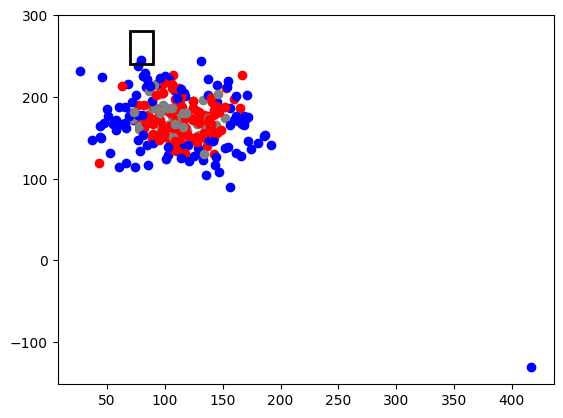

,game_ID,atBatResult,halfInning,inning,batter_id,pitcher_id,batter_name,pitcher_name,batter_hand,pitcher_hand,play_description,isInPlay,isStrike,isBall,pitchNumber,pitch_type,isOut,current_balls,current_strikes,current_outs,pitchStartSpeed,pitchEndSpeed,pitchStrikeZoneTop,pitchStikeZoneBottom,pitchZone,pitchTypeConfidence,aY,aZ,pfxX,pfxZ,pX,pZ,vX0,vY0,vZ0,x,y,x0,y0,z0,aX,breakAngle,breakLength,breakY,breakVertical,breakVerticalInduced,breakHorizontal,spinRate,spinDirection,pitchesThrownByCurrentPitcher,cumulativeBalls,cumulativeStrikes,stat_category,pitcher_pitches_thrown_in_inning
0,529406,Flyout,top,1,605141,502042,Mookie Betts,Chris Archer,R,R,"In play, out(s)",True,False,False,1,Four-Seam Fastball,True,0,0,0,93.1,85.0,3.058897,1.203787,1.0,2.0,29.717387,-13.727842,-3.494046,9.980379,-0.280939,2.661554,5.842988,-135.164615,-6.827116,127.71,166.92,-2.017608,50.0,6.185620,-6.457861,19.2,3.6,24.0,-15.2,17.2,5.2,2045.0,196.0,1,0,0,Other,1
1,529406,Groundout,top,1,643217,502042,Andrew Benintendi,Chris Archer,L,R,Called Strike,False,True,False,1,Four-Seam Fastball,False,0,1,1,93.9,85.4,3.517506,1.614818,4.0,2.0,31.508174,-11.552041,-3.010252,11.020439,-0.653021,2.251208,4.979586,-136.315997,-8.286604,141.89,178.00,-2.116920,50.0,6.138578,-5.632937,18.0,3.6,24.0,-13.2,18.6,4.4,2159.0,193.0,2,0,1,Other,2
2,529406,Groundout,top,1,643217,502042,Andrew Benintendi,Chris Archer,L,R,Foul,False,True,False,2,Four-Seam Fastball,False,0,2,1,94.8,86.0,3.421106,1.512101,1.0,2.0,32.793451,-12.690361,-4.952372,10.221813,-0.747896,3.093684,5.544162,-137.731357,-5.919226,145.51,155.24,-2.150921,50.0,6.141258,-9.439663,30.0,3.6,24.0,-13.6,17.6,7.8,2212.0,203.0,3,0,2,Other,3
3,529406,Groundout,top,1,643217,502042,Andrew Benintendi,Chris Archer,L,R,"In play, out(s)",True,False,False,3,Changeup,True,0,2,1,87.9,80.0,3.422584,1.513540,4.0,2.0,27.771391,-18.041572,-7.650419,8.605078,-0.720945,2.690855,6.216304,-127.733983,-5.004133,144.48,166.13,-2.199316,50.0,6.105662,-12.564601,30.0,6.0,24.0,-21.4,14.9,12.5,1832.0,220.0,4,0,0,Other,4
4,529406,Strikeout,top,1,434670,502042,Hanley Ramirez,Chris Archer,R,R,Foul,False,True,False,1,Four-Seam Fastball,False,0,1,2,94.1,85.6,3.553354,1.563837,5.0,2.0,31.332439,-11.185967,-4.117972,11.140593,0.127003,2.887081,6.571235,-136.691624,-6.849673,112.16,160.83,-1.777817,50.0,6.200513,-7.757966,26.4,3.6,24.0,-12.5,19.2,6.1,2254.0,197.0,5,0,3,Strikeout,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,529406,Groundout,top,9,598265,517008,Jackie Bradley Jr.,Alex Colomé,L,R,Called Strike,False,True,False,1,Cutter,False,0,1,2,88.6,81.1,3.339473,1.548490,1.0,2.0,27.275762,-25.295508,1.157115,4.093858,-0.663325,3.037366,0.929125,-128.934319,-3.127381,142.29,156.73,-1.178876,50.0,6.221906,1.944196,4.8,6.0,24.0,-28.4,7.1,-2.4,2089.0,161.0,12,0,6,Other,12
273,529406,Groundout,top,9,598265,517008,Jackie Bradley Jr.,Alex Colomé,L,R,Ball In Dirt,False,False,True,2,Cutter,False,1,1,2,88.2,80.8,3.417572,1.548490,13.0,2.0,27.945041,-26.101465,2.694639,3.678440,-0.996992,0.714209,-0.028410,-128.071692,-8.121110,155.00,219.50,-1.335398,50.0,5.985895,4.448467,9.6,7.2,24.0,-31.2,5.2,-5.0,1952.0,135.0,13,4,0,Other,13
274,529406,Groundout,top,9,598265,517008,Jackie Bradley Jr.,Alex Colomé,L,R,Foul,False,True,False,3,Cutter,False,1,2,2,88.0,80.9,3.320372,1.441543,4.0,2.0,26.237572,-27.159683,2.161107,3.019035,-0.784304,2.119320,0.694412,-128.022379,-4.801328,146.90,181.56,-1.339718,50.0,6.142742,3.589419,7.2,7.2,24.0,-31.2,4.7,-4.1,2065.0,138.0,14,0,7,Other,14
275,529406,Groundout,top,9,598265,517008,Jackie Bradley Jr.,Alex Colomé,L,R,Ball In Dirt,False,False,True,4,Cutter,False,2,2,2,88.4,80.8,3.438493,1.549932,13.0,2.0,28.720301,-22.492674,0.376474,5.865135,-0.383870,-0.187290,2.187201,-128.246492,-10.885485,131.63,243.84,-1.299759,50.0,5.895374,0.621432,2.4,6.0,24.

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


game_pbp = all_play_by_play[all_play_by_play['game_ID'] == 529406]

fig, ax = plt.subplots()

for idx, row in game_pbp.iterrows():
    if row['isStrike']:
        color = 'red'
    elif row['isBall']:
        color = 'blue'
    else:
        color = 'gray'
    
    ax.scatter(row['x'], row['y'], color=color)
    
strike_zone = patches.Rectangle((70, 240), 20, 40, fill=False, color='black', linewidth=2, label='Strike Zone')

ax.add_patch(strike_zone)


plt.show()

game_pbp

In [10]:
pitcher_boxscores['K_greater_than_MA'] = pitcher_boxscores.apply(lambda row: row['k'] > row['strikeout_MA3'], axis=1)
pitcher_boxscores['walks_greater_than_MA'] = pitcher_boxscores.apply(lambda row: row['bb'] > row['walks_MA3'], axis=1)
pitcher_boxscores['h_greater_than_MA'] = pitcher_boxscores.apply(lambda row: row['h'] > row['h_MA3'], axis=1)


temp_df = pitcher_boxscores[pitcher_boxscores['Name'] == 'Corbin Burnes']
#temp_df[['Name', 'k', 'strikeout_MA3', 'K_greater_than_MA']].tail(25)

temp_df[temp]

KeyError: 'strikeout_MA3'

In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Assuming 'df' is your DataFrame and 'p' is the column for pitch counts (your target variable)
df = pitcher_boxscores
df = df.replace('-.--', np.nan)
df.replace([np.inf, -np.inf], np.nan, inplace=True)


features = ['ip', 'h', 'r', 'er', 'bb', 'k', 'hr', 's', 'era', 'personId', 'isStarter', 'pitching_outs', 'pitches_per_out', 'seasonNumber', 'pitch_count_MA3']  # Adjust based on available data
target = 'p'

X = df[features]
y = df[target]

# Converting 'game_date' to a numerical feature, e.g., day of the year
#X['game_date'] = pd.to_datetime(X['game_date']).dt.dayofyear

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Feature scaling
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))  # Regression model
])

model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', RandomForestRegressor(random_state=42))])

In [51]:
from sklearn.metrics import mean_absolute_error

predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae}')


Mean Absolute Error: 0.3935322632144205


In [52]:
for pitcher_name in expectedPitcher_id:
    pitcher_boxscore = df[(df['Name'] == pitcher_name) & (df['seasonNumber'].isin([2023,2024]))]


    input_features = {
        'ip': [pitcher_boxscore['ip'].mean()],  # Season average innings pitched per game
        'h': [pitcher_boxscore['h'].mean()],   # Season average hits allowed per game
        'r': [pitcher_boxscore['r'].mean()],   # Season average runs allowed per game
        'er': [pitcher_boxscore['er'].mean()],  # Season average earned runs per game
        'bb': [pitcher_boxscore['bb'].mean()],  # Season average walks (bases on balls) allowed per game
        'k': [pitcher_boxscore['k'].mean()],   # Season average strikeouts per game
        'hr': [pitcher_boxscore['hr'].mean()],  # Season average home runs allowed per game
        's': [pitcher_boxscore['s'].mean()],    # Season average number of strikes (this might need estimation based on total pitches and strike percentage)
        'era': [pitcher_boxscore['era'].astype(float).mean()],# Season ERA (Earned Run Average)
        'personId': [pitcher_boxscore['personId'].iloc[0]], # Unique identifier for the pitcher
        'isStarter': [True],  # Assuming the pitcher is starting; typically 1 for yes since we're predicting for starters
        'pitching_outs': [pitcher_boxscore['pitching_outs'].mean()], # Season average number of outs pitched per game (assuming 3 outs per inning pitched)
        'pitches_per_out': [pitcher_boxscore['pitches_per_out'].mean()], # Historical average of pitches per out for the pitcher
        'seasonNumber': [2024],  # Season number, useful if the model includes data from multiple seasons
        'pitch_count_MA3': [pitcher_boxscore['pitch_count_MA3'].iloc[-1]], # Moving average of pitch counts over the last 3 games or similar metric
    }


    input_data = pd.DataFrame(input_features)

    # Preprocess input_data as you did with your training data
    # This includes scaling numerical features and encoding categorical ones

    # Predicting with the model

    predicted_pitch_count = model.predict(input_data)

    print(f"Predicted pitch count for the {pitcher_name}'s next game: {predicted_pitch_count[0]}")



Predicted pitch count for the Reid Detmers's next game: 97.71
Predicted pitch count for the Steven Matz's next game: 77.57
Predicted pitch count for the Ryan Feltner's next game: 86.9
Predicted pitch count for the Jordan Wicks's next game: 86.56
Predicted pitch count for the Michael Wacha's next game: 95.06
Predicted pitch count for the Dane Dunning's next game: 81.0
Predicted pitch count for the Jake Irvin's next game: 93.39
Predicted pitch count for the Pablo López's next game: 95.0
Predicted pitch count for the Michael King's next game: 39.98
Predicted pitch count for the Freddy Peralta's next game: 99.04
Predicted pitch count for the Max Fried's next game: 96.03
Predicted pitch count for the Clarke Schmidt's next game: 86.01
Predicted pitch count for the Andrew Abbott's next game: 93.18
Predicted pitch count for the Keaton Winn's next game: 70.87
Predicted pitch count for the Bailey Falter's next game: 74.04
Predicted pitch count for the Tanner Houck's next game: 85.85
Predicted pi

In [53]:
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

# Assuming batter_boxscores, predicted_lineups, and team_id_dict are predefined
prop_list = ['r', 'h', 'doubles', 'triples', 'hr', 'sb', 'bb', 'k', 'singles', 'TB']

def process_player_prop(player, prop):
    """
    Processes a single player for a given prop and returns dictionaries 
    for overall, home, and away data.
    """
    current_player = batter_boxscores[batter_boxscores['Name'] == player][::-1]
    player_dicts = []

    # Common logic for extracting prop data
    def create_player_dict(context, player_data):
        player_dict = {'Name': player, 'Prop': prop, 'Line': 0.5, 'Hit Rate': None}
        for x in range(1, 11):
            player_dict[f"L{x}"] = None
        prop_data = player_data[prop].to_list()
        for num in range(0, min(10, len(player_data))):
            player_dict[f"L{num + 1}"] = prop_data[num]
        hits = [stat >= 0.5 for stat in prop_data[:10]]
        player_dict['Hit Rate'] = sum(hits) / len(hits) * 100 if hits else None
        return player_dict

    # Process for overall
    player_dicts.append(create_player_dict('overall', current_player))

    # Process for away
    away_data = current_player[current_player['Team'] == current_player['away_name']]
    player_dicts.append(create_player_dict('away', away_data))

    # Process for home
    home_data = current_player[current_player['Team'] == current_player['home_name']]
    player_dicts.append(create_player_dict('home', home_data))

    return player_dicts

# Extract active players list based on team_id_dict and predicted_lineups
activePlayers = [player for team_id in predicted_lineups for player in predicted_lineups[team_id] if team_id in team_id_dict]

# Parallel processing
l10chart_overall, l10chart_home, l10chart_away = [], [], []
with ThreadPoolExecutor(max_workers=100) as executor:
    futures = [executor.submit(process_player_prop, player, prop) 
               for player in activePlayers for prop in prop_list]
    for future in futures:
        result = future.result()
        l10chart_overall.append(result[0])
        l10chart_home.append(result[1])
        l10chart_away.append(result[2])

# The final lists are ready and contain the processed data for each player and prop


NameError: name 'team_id_dict' is not defined

In [ ]:
l10chart_overall = pd.DataFrame(l10chart_overall).drop_duplicates(keep='first')
l10chart_home = pd.DataFrame(l10chart_home).drop_duplicates(keep='first')
l10chart_away = pd.DataFrame(l10chart_away).drop_duplicates(keep='first')

with pd.ExcelWriter('l10_charts.xlsx', engine='openpyxl') as writer:
    l10chart_overall.to_excel(writer, sheet_name='Overall')
    l10chart_home.to_excel(writer, sheet_name='Home')
    l10chart_away.to_excel(writer, sheet_name='Away')

In [ ]:
l10chart_away

,Name,Prop,Line,Hit Rate,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10
0,Charlie Blackmon,r,0.5,40.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,2.0
1,Charlie Blackmon,h,0.5,70.0,1.0,0.0,0.0,0.0,2.0,3.0,1.0,2.0,2.0,2.0
2,Charlie Blackmon,doubles,0.5,40.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0
3,Charlie Blackmon,triples,0.5,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Charlie Blackmon,hr,0.5,10.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,Michael A. Taylor,sb,0.5,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2696,Michael A. Taylor,bb,0.5,40.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0
2697,Michael A. Taylor,k,0.5,90.0,1.0,2.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,1.0
2698,Michael A. Taylor,singles,0.5,30.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
